In [6]:
import numpy as np
import pandas as pd
from CHEM274.importer_snippets import load_experiment
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.style.use('JGW-PPT')
import os
os.getcwd()

'C:\\Users\\jgage\\Documents\\GitHub\\CHEM274\\CV-fitting'

C:\Users\jgage\AppData\Local\Temp/ipykernel_24848/3362043461.py:51: PeakPropertyWarning: some peaks have a width of 0
  find_ipa = find_peaks(exp.data['savgol_iw'], height=0, width=3600) # Must give minimum height to get peak_heights dict.


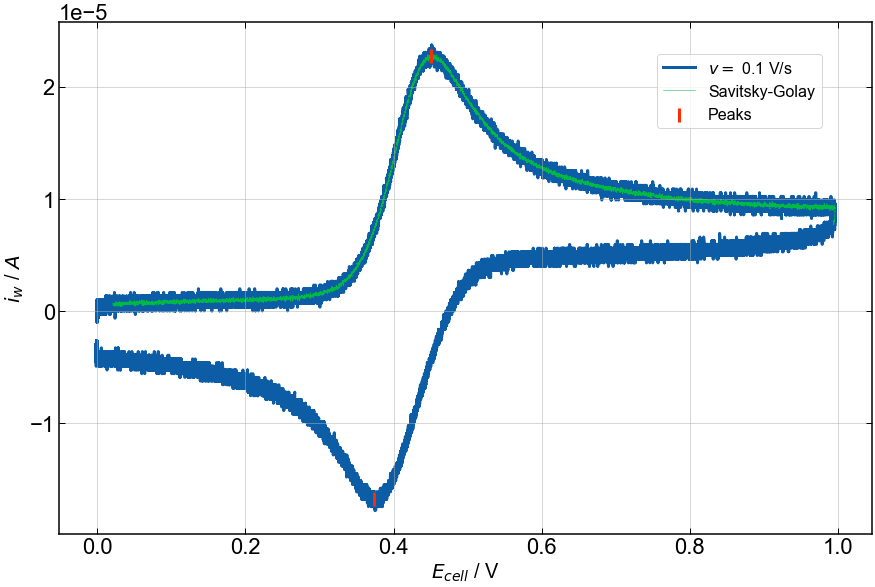

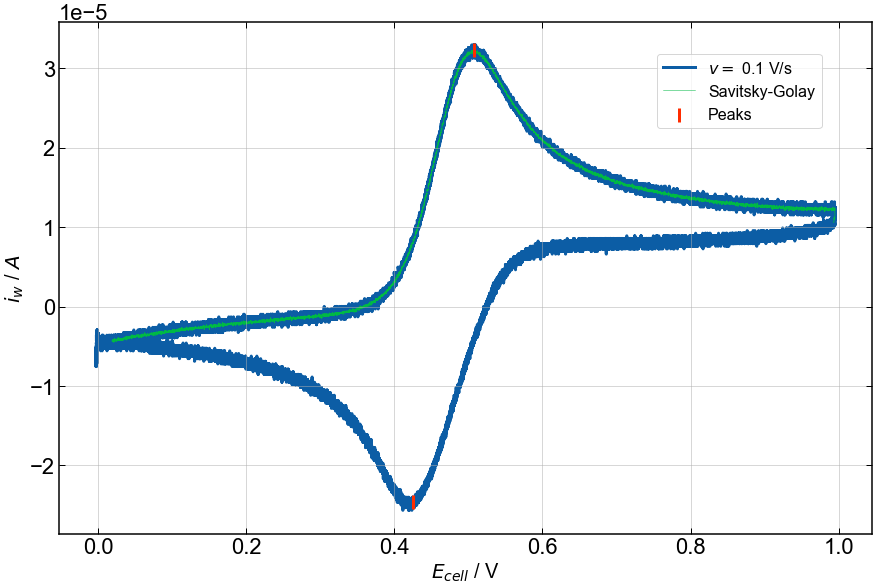

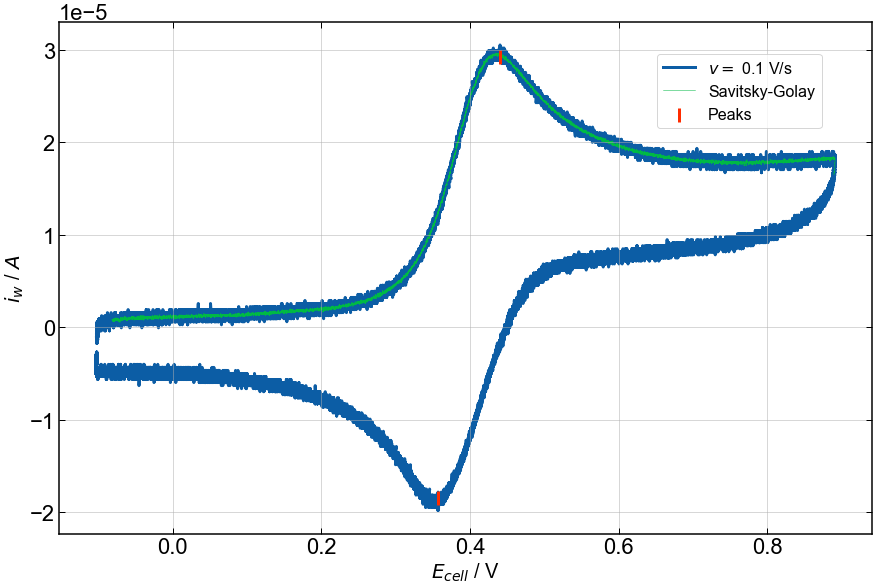

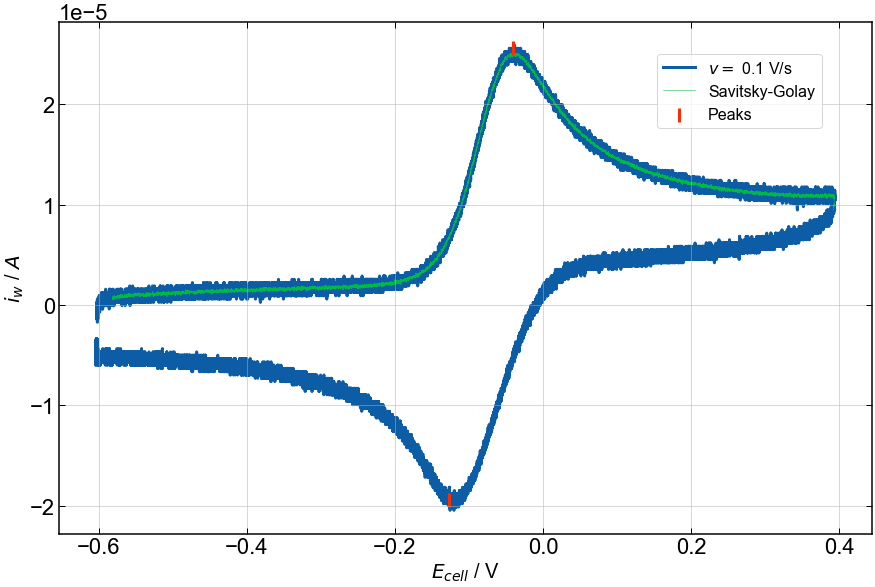

In [43]:
# Import Data
FcMeCN = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeCN_0.1Vs-1_P-06-04")
FcMeAc = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.1Vs-1_P-07-02")
FcMix = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_mix_0.1Vs-1_P-08-13")
FcStar = load_experiment(csv_dirname=r"..\data\CV_FcStar_GC_MeAc_0.1Vs-1_P-09-03")

exp_series = [FcMeCN, FcMeAc, FcMix, FcStar]
# exp_series = [FcMeCN]

i = 0 # for indexing arrays
ref_check = [False, False, True, True]
Ru = np.array([404, 400, 403, 444]) # Ohms
# pp_width = np.array([3600, 3600, 3600, 100])

picked_peaks = []

for exp in exp_series:
    # print(i, ref_check[i], Ru[i], sep='\n')
    # Reference calibration
    if ref_check[i]:
        exp.data['Ecell'] = exp.data['Ecell'] - 0.101984 # Apply iR correction for Ru determined by EIS fitting to the Randles circuit


    exp.data['Ecell'] = exp.data['Ecell'] - (Ru[i] * exp.data['iw'].abs()) # 100% Compensation!

    # Figure out what the real h_time was. This is different from the programmed h_time due to automatic sample number rounding during acquisition.
    h_pot = exp.data.loc[0, 'E_program']
    h_time = exp.data.loc[exp.data['E_program'] > h_pot]['t'].min()
    # Put it in params
    h_time_row = pd.Series(['h_time', h_time], index=['parameter', 'value'])
    exp.params = exp.params.append(h_time_row, ignore_index=True)

    scan_direction_bools = []

    Ecell_lead_time = .18 # Manually set delay parameter in seconds
    switching_time = (h_time + exp.data['t'].max()) / 2 - Ecell_lead_time
    for j in range(len(exp.data['E_program'])):
        # This checks every data point individually, so it's a bit slow
        if exp.data.loc[j, 't'].item() < h_time:
            scan_direction_bools.append(None)
        elif exp.data.loc[j, 't'].item() < switching_time:
            scan_direction_bools.append(True)
        else:
            scan_direction_bools.append(False)
    exp.data['forward'] = scan_direction_bools

    # Smooth data using the Savitski Golay method
    exp.data['savgol_iw'] = savgol_filter(exp.data['iw'], 25, 3)


    # Maxima
    find_ipa = find_peaks(exp.data['savgol_iw'], height=0, width=3600) # Must give minimum height to get peak_heights dict.
    ipa, Epa = exp.data['iw'][find_ipa[0]].to_numpy(), exp.data['Ecell'][find_ipa[0]].to_numpy()

    # Invert signal to find minima - Signals are negative but indicies are correct!
    find_ipc = find_peaks(-exp.data['savgol_iw'], height=0, width=3600) # Remember to un-invert anytime if calling ipc values from find_ipc, but not indices.
    ipc, Epc = exp.data['iw'][find_ipc[0]].to_numpy(), exp.data['Ecell'][find_ipc[0]].to_numpy()

    peaks = {'ipa': ipa[0], 'Epa': Epa[0], 'ipc': ipc[0], 'Epc': Epc[0]}
    picked_peaks.append(pd.DataFrame(data=peaks, index=[0]))
    # print(peaks)

    # Now some plotting
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    ax.plot(exp.data['Ecell'], exp.data['iw'], label = '$v=$ '+str(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' V/s', zorder=0)
    ax.plot(exp.data.loc[exp.data['forward']==True]['Ecell'], exp.data.loc[exp.data['forward']==True]['savgol_iw'], color='C2', label='Savitsky-Golay', lw=.5, zorder=.5)
    ax.scatter([*Epa, *Epc], [*ipa, *ipc], color='C1', label='Peaks', marker='|', s=200, zorder=1)
    fig.tight_layout()

    ax.set_xlabel('$E_{cell}$ / V')
    ax.set_ylabel('$i_{w}$ / $A$')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fig.legend(loc=(0.75, 0.78))

    # plt.show()

    i += 1


[-1.00633078e-05  1.67199307e-05]
[-1.00331281e-05  1.95977880e-05]
[-2.35888335e-05  3.71514075e-05]
[-2.21994252e-06  1.05750789e-05]


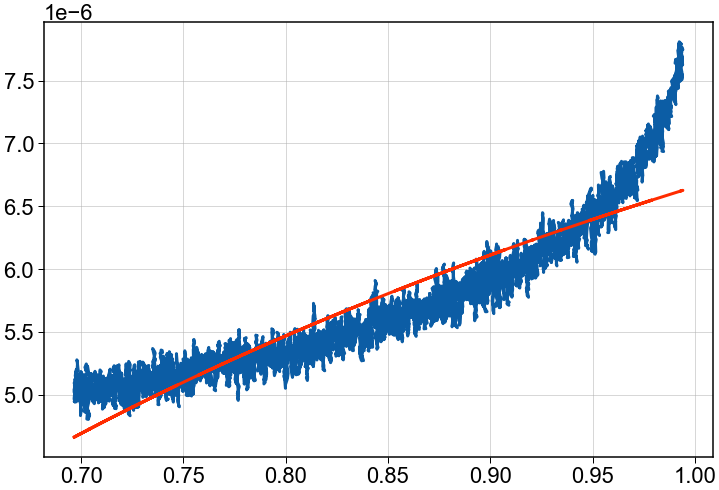

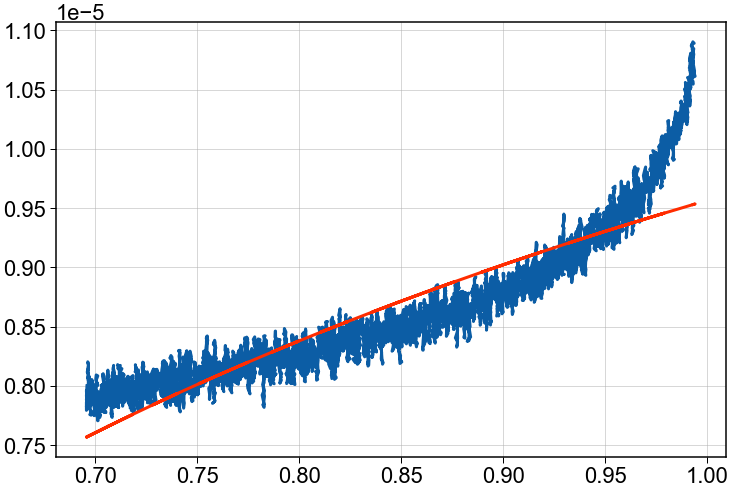

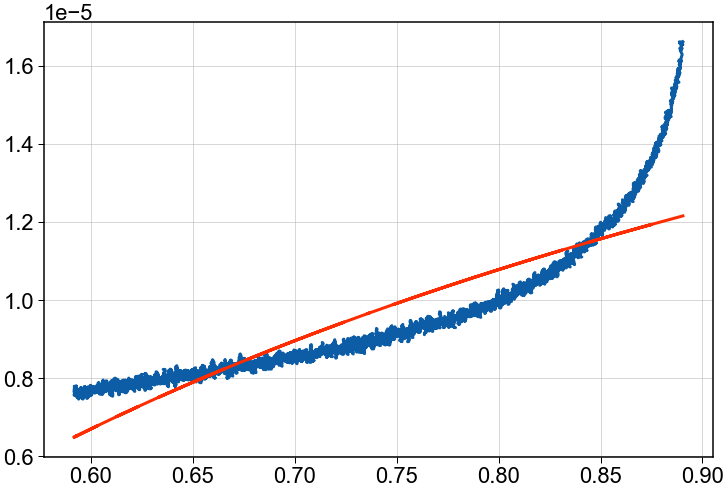

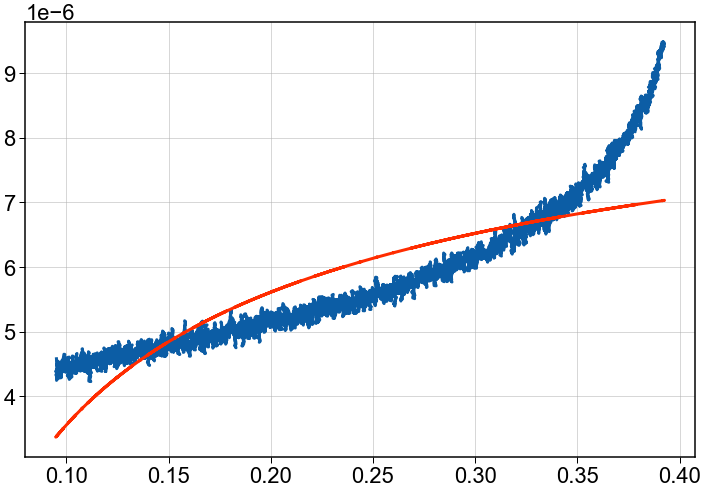

In [53]:
for exp in exp_series:
    exp_data_rev = exp.data.loc[exp.data['forward']==False]

    fit_length = 0.3 # Length of transient to fit in V
    switch_pot = exp.data.loc[exp.data['forward']==True]['Ecell'].max()
    trans_x = exp_data_rev.loc[exp.data['Ecell'].between(switch_pot - fit_length, switch_pot)]['Ecell']
    trans_y = exp_data_rev.loc[exp.data['Ecell'].between(switch_pot - fit_length, switch_pot)]['savgol_iw']

    guesses = np.array([1e-10, .5])
    fit, cov = curve_fit(lambda E, a, b: (a / np.sqrt(E)) + b, trans_x, trans_y, guesses)

    print(fit)

    fig, ax = plt.subplots()
    ax.plot(trans_x, trans_y)
    ax.plot(trans_x, fit[0]/np.sqrt(trans_x) + fit[1])





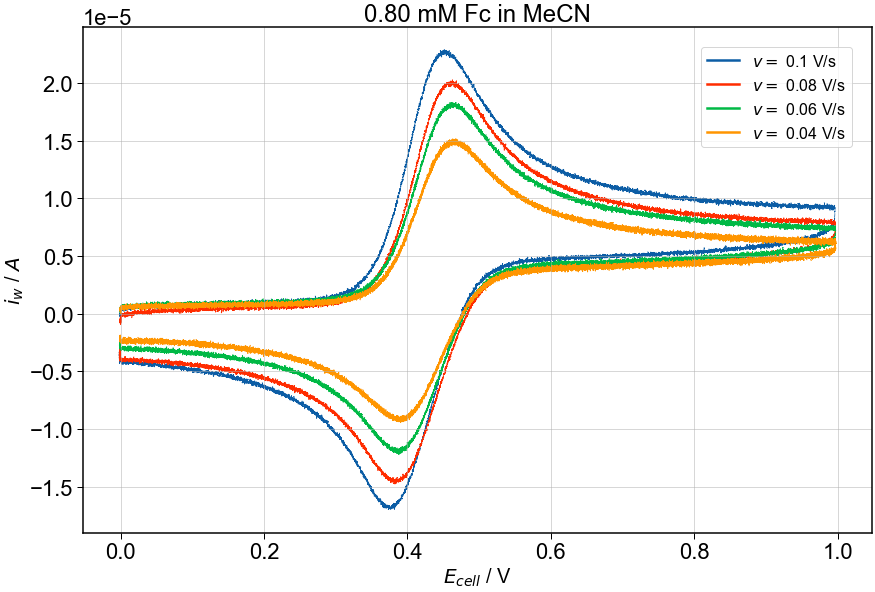

In [13]:
fig = plt.figure()
ax = fig.add_subplot()

for exp in exp_series:
    ax.plot(exp.data['Ecell'], exp.data['savgol_iw'],
            label='$v=$ '+str(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' V/s',
            lw=.5, zorder=.5)

fig.tight_layout()

ax.set_xlabel('$E_{cell}$ / V')
ax.set_ylabel('$i_{w}$ / $A$')
ax.set_title('0.80 mM Fc in MeCN')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
leg = fig.legend(loc=(0.80, 0.75))

for line in leg.get_lines():
    line.set_linewidth(2.5)

D = 3.0262159049060432e-06 cm2/s
[[1.43362005e-12]]
[-5.31348225e-07 -3.80045489e-07  7.60585016e-07  4.46078193e-07]
1.204240830383083e-12
3.040766964772924e-11
0.007505845559575015
4.746570466093676e-07
0.9603968063210983
[1.19733874e-06]


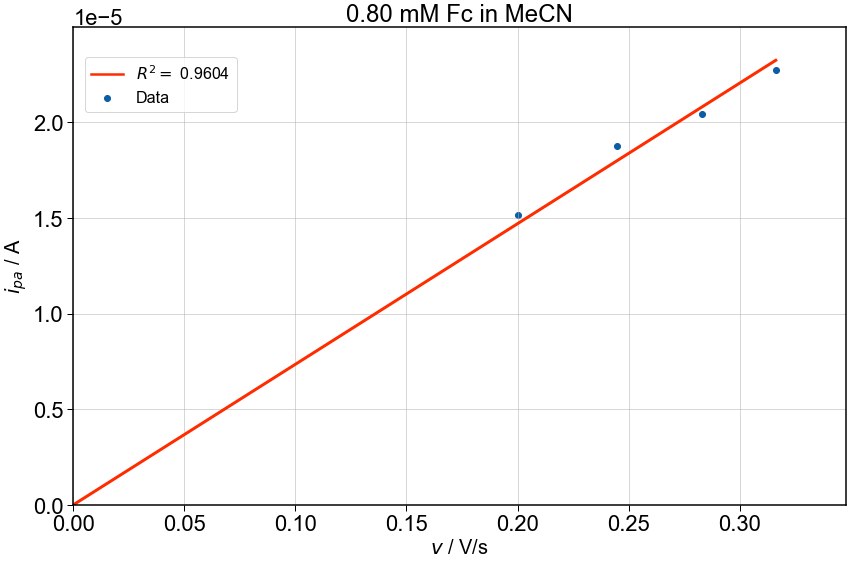

In [16]:
x, y = [], []
for i in range(len(exp_series)):
    x.append(np.sqrt(exp_series[i].params.loc[exp_series[i].params['parameter']=='scan_rate', 'value'].item()))
    y.append(picked_peaks[i]['ipa'].item())

x, y = np.array(x), np.array(y)

x2 = np.linspace(0, np.max(x), 1000)

guess_m = 1.0e-04
fit, cov = curve_fit(lambda x, m : x*m, x, y, guess_m)

# Get the fitting parameter report manually, because scipy couldn't be bothered to.
residuals = y - fit[0]*x
ss_res = np.sum(residuals**2)
ss_yy = np.sum((y - np.mean(y)) ** 2)
ss_xx = np.sum((x - np.mean(x)) ** 2)
ss_xy = np.sum((x - np.mean(x))*(y - np.mean(y)))
r_squared = 1 - (ss_res / ss_yy)
std_err = np.sqrt(np.diag(cov))

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x, y, label='Data', c='C0')
ax.plot(x2, fit[0]*x2, label='$R^2 =$ '+ '{:.4f}'.format(r_squared), c='C1')

ax.set_xlabel('$v$ / V/s')
ax.set_ylabel('$i_{pa}$ / A')
ax.set_title('0.80 mM Fc in MeCN')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.set_xlim(0, np.max(x)*1.1)
ax.set_ylim(0, np.max(y)*1.1)

fig.tight_layout()

leg = fig.legend(loc=(0.10, 0.80))
for line in leg.get_lines():
    line.set_linewidth(2.5)

# Solving the Randles-Sevcik equation
A = np.pi * (.5/2)**2 # cm2
CR = 0.8 / (10**6) # mol/cm3
D = (fit[0]  / ((2.69*10**5) * A * CR))**2 # cm2/s
print('D = '+str(D)+' cm2/s')

print(cov, residuals, ss_res, ss_yy, ss_xx, ss_xy, r_squared, std_err, sep='\n')
# fig.savefig(r'..\data\figs\Fc_MeCN_Randles-Sevcik.png')